In [28]:
# Imports
import pandas as pd
import numpy as np
import sqlite3
import dataprep
from dataprep.eda import create_report
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, pearsonr
import matplotlib.pyplot as plt


In [29]:
path = '/Users/Marcy_Student/Desktop/CID_data-slayer-corps/sql/CID_database_clean.db'
conn = sqlite3.connect(path)
cursor = conn.cursor()

# Get all table names
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(tables_query, conn)
print("Available tables in database:")
print(tables)
print(f"\nTotal tables: {len(tables)}")

table = ['dim_environment', 'dim_location', 'dim_demographic','fact_school_outcomes']

results = {}
for t in table:
    query = f'SELECT * FROM {t}'
    results[t] = pd.read_sql_query(query, conn)

dim_environment = results['dim_environment']
dim_location = results['dim_location']
dim_demographic = results['dim_demographic']
fact_school_outcomes = results['fact_school_outcomes']

Available tables in database:
                   name
0       dim_environment
1          dim_location
2       dim_demographic
3  fact_school_outcomes
4       sqlite_sequence

Total tables: 5


## DEEP ANALYSIS on the Subgroup level

Merge `fact_school_outcomes` (subgroup CCR) + `dim_demographic` (demographic concentration) + `dim_environment` (stressors) + `dim_location` (borough). Convert `ccr_rate` to the 0–100 percentage scale and flag suppressed records.

In [30]:
# ============================================================
# Build the merged subgroup dataset
# ============================================================

# Convert ccr_rate to 0-100 percentage scale
subgroup_df = fact_school_outcomes.copy()
subgroup_df['ccr_pct'] = subgroup_df['ccr_rate'] * 10000

# Merge with demographic concentration
subgroup_df = subgroup_df.merge(
    dim_demographic[['DBN', 'Subgroup', 'student_percent', 'nearby_student_percent',
                     'pct_students_advanced_courses', 'teacher_percent']],
    on=['DBN', 'Subgroup'], how='left'
)

# Merge with environment stressors (school-level)
env_cols = ['DBN', 'economic_need_index', 'percent_temp_housing',
            'teaching_environment_pct_positive', 'avg_student_attendance','metric_value_4yr_ccr_all_students']
subgroup_df = subgroup_df.merge(dim_environment[env_cols], on='DBN', how='left')

# Merge with location (borough)
subgroup_df = subgroup_df.merge(dim_location[['DBN', 'borough']], on='DBN', how='left')

# Flag suppression status
subgroup_df['ccr_status'] = np.where(
    subgroup_df['ccr_pct'].notna(), 'reported',
    np.where(subgroup_df['n_count_ccr'].notna(), 'suppressed (n<15)', 'no cohort')
)

print(f'Subgroup dataset shape: {subgroup_df.shape}')
print(f'\nCCR status by subgroup:')
status_table = pd.crosstab(subgroup_df['Subgroup'], subgroup_df['ccr_status'], margins=True)
print(status_table)

print(f'\nReported CCR summary by subgroup:')
reported = subgroup_df[subgroup_df['ccr_pct'].notna()]
summary = reported.groupby('Subgroup').agg(
    N=('ccr_pct', 'count'),
    Mean_CCR=('ccr_pct', 'mean'),
    Median_CCR=('ccr_pct', 'median'),
    Std_CCR=('ccr_pct', 'std'),
    Min_CCR=('ccr_pct', 'min'),
    Max_CCR=('ccr_pct', 'max')
).round(1)
print(summary.to_string())

Subgroup dataset shape: (2024, 26)

CCR status by subgroup:
ccr_status  no cohort  reported  suppressed (n<15)   All
Subgroup                                                
Asian             166       120                220   506
Black             100       299                107   506
Hispanic           89       369                 48   506
White             144       100                262   506
All               499       888                637  2024

Reported CCR summary by subgroup:
            N  Mean_CCR  Median_CCR  Std_CCR  Min_CCR  Max_CCR
Subgroup                                                      
Asian     120      77.4        78.4     13.1     45.0     99.1
Black     299      48.9        46.2     14.1     21.5     99.0
Hispanic  369      50.4        47.1     14.8     22.8     95.1
White     100      74.3        77.4     16.2     37.3     98.3


## 1. Subgroup CCR Distributions & Disparities

Compare CCR distributions across the four subgroups. Key questions:
- **How wide is the gap** between the highest- and lowest-performing subgroups?
- **Which subgroups have the most variance** — indicating inconsistent outcomes across schools?
- **Does the disparity persist within the same school** (readiness gap)?

/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_79736/2108840282.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Asian', 'Black', 'Hispanic', 'White'],


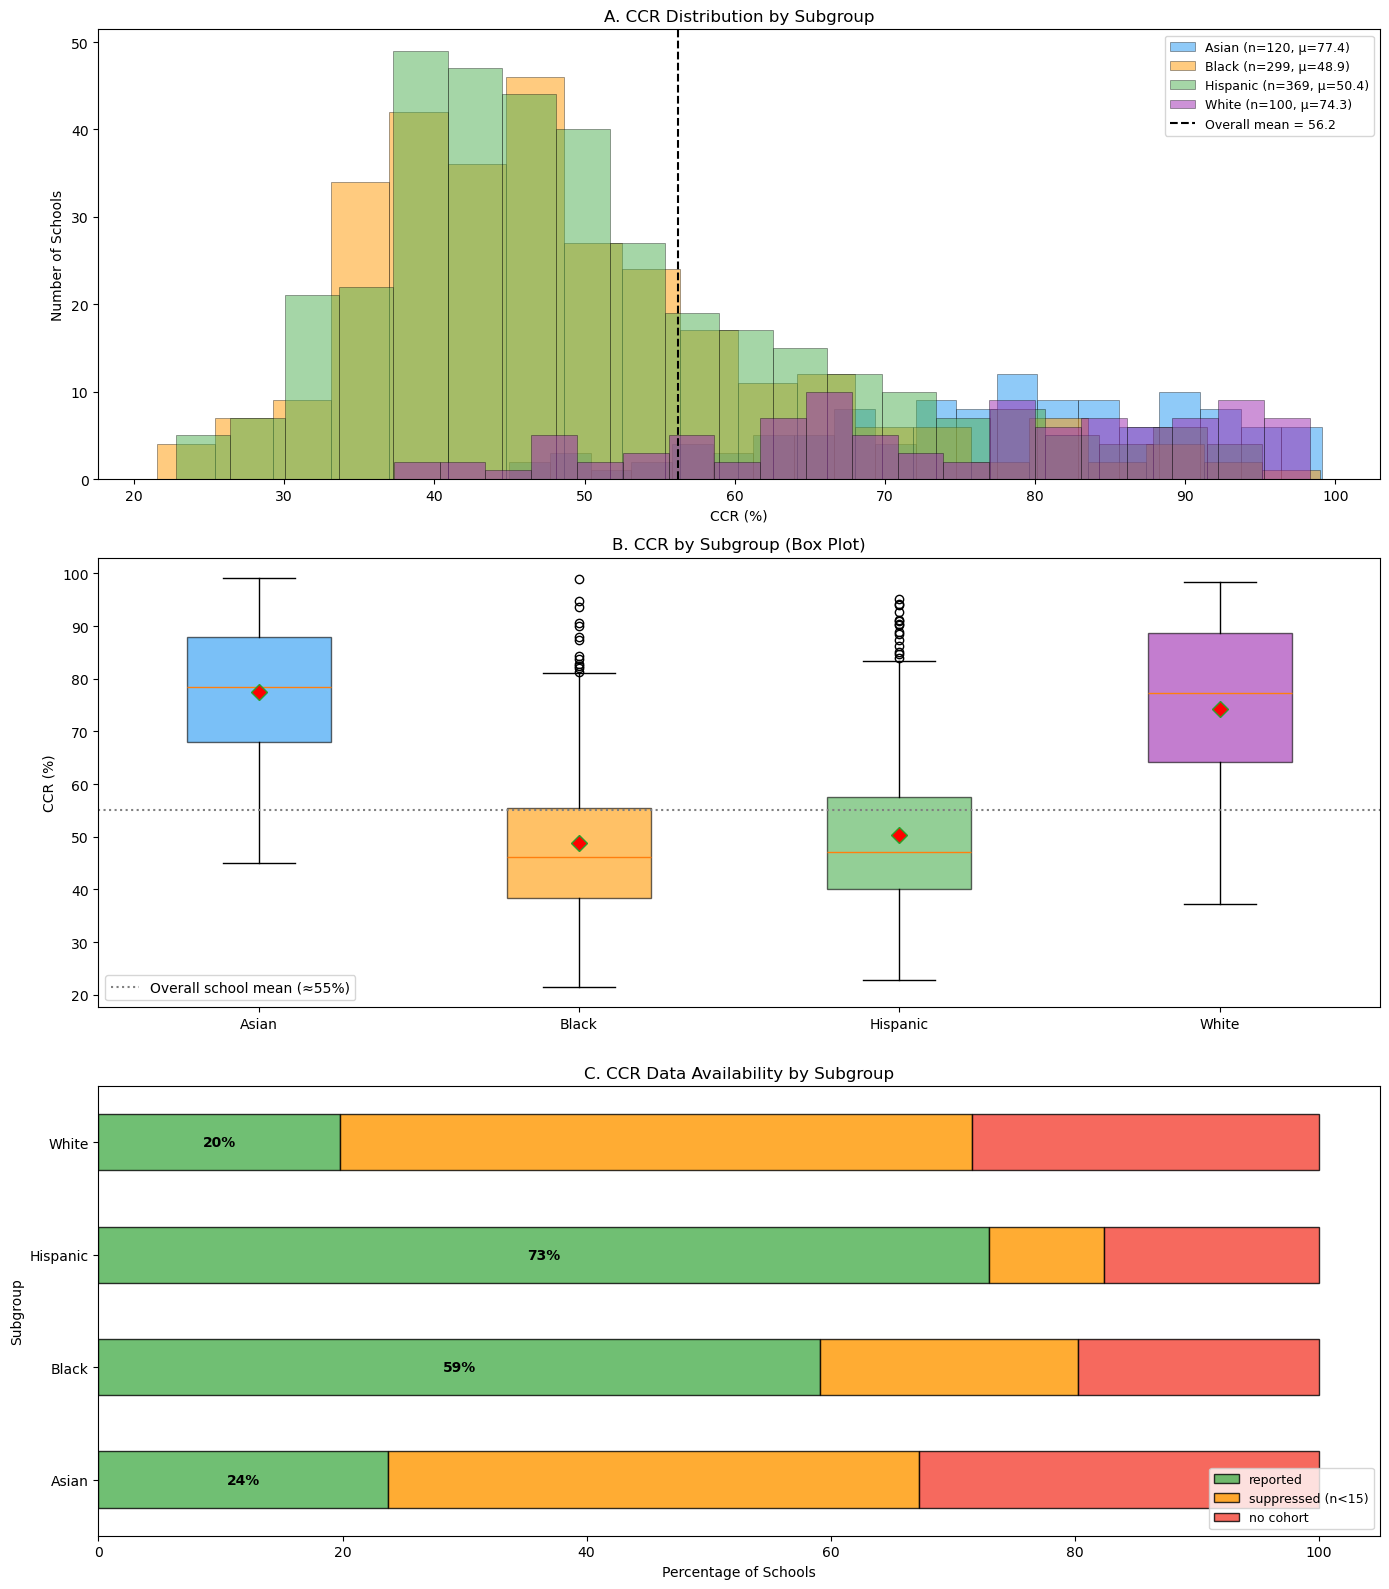


  Mean CCR ranking:
    1. Asian        77.4%
    2. White        74.3%
    3. Hispanic     50.4%
    4. Black        48.9%


In [31]:
fig, axes = plt.subplots(3, 1, figsize=(14, 16))

# --- Panel A: CCR Distribution by Subgroup ---
subgroup_colors = {'Asian': '#2196F3', 'Black': '#FF9800', 'Hispanic': '#4CAF50', 'White': '#9C27B0'}
for sg in ['Asian', 'Black', 'Hispanic', 'White']:
    data = reported[reported['Subgroup'] == sg]['ccr_pct']
    axes[0].hist(data, bins=20, alpha=0.5, label=f'{sg} (n={len(data)}, μ={data.mean():.1f})',
                     color=subgroup_colors[sg], edgecolor='black', linewidth=0.5)
axes[0].axvline(x=reported['ccr_pct'].mean(), color='black', linestyle='--', linewidth=1.5, label=f'Overall mean = {reported["ccr_pct"].mean():.1f}')
axes[0].set_xlabel('CCR (%)')
axes[0].set_ylabel('Number of Schools')
axes[0].set_title('A. CCR Distribution by Subgroup')
axes[0].legend(fontsize=9)

# --- Panel B: Box plot comparison ---
box_data = [reported[reported['Subgroup'] == sg]['ccr_pct'].values for sg in ['Asian', 'Black', 'Hispanic', 'White']]
bp = axes[1].boxplot(box_data, labels=['Asian', 'Black', 'Hispanic', 'White'],
                         patch_artist=True, showmeans=True,
                         meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
for patch, sg in zip(bp['boxes'], ['Asian', 'Black', 'Hispanic', 'White']):
    patch.set_facecolor(subgroup_colors[sg])
    patch.set_alpha(0.6)
axes[1].set_ylabel('CCR (%)')
axes[1].set_title('B. CCR by Subgroup (Box Plot)')
axes[1].axhline(y=55, color='gray', linestyle=':', label='Overall school mean (≈55%)')
axes[1].legend()

# --- Panel C: Suppression rates by subgroup ---
suppression_data = subgroup_df.groupby('Subgroup')['ccr_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
suppression_order = ['reported', 'suppressed (n<15)', 'no cohort']
suppression_data = suppression_data[[c for c in suppression_order if c in suppression_data.columns]]
suppression_data.plot(kind='barh', stacked=True, ax=axes[2],
                       color=['#4CAF50', '#FF9800', '#f44336'], edgecolor='black', alpha=0.8)
axes[2].set_xlabel('Percentage of Schools')
axes[2].set_title('C. CCR Data Availability by Subgroup')
axes[2].legend(loc='lower right', fontsize=9)
for i, sg in enumerate(suppression_data.index):
    reported_pct = suppression_data.loc[sg, 'reported']
    axes[2].text(reported_pct / 2, i, f'{reported_pct:.0f}%', ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

sg_means = reported.groupby('Subgroup')['ccr_pct'].mean().sort_values(ascending=False)
print(f'\n  Mean CCR ranking:')
for i, (sg, mean) in enumerate(sg_means.items(), 1):
    print(f'    {i}. {sg:<12} {mean:.1f}%')


## 2. Environmental Stressors × Subgroup — Differential Impact

The beta model identified **economic need, housing instability, and attendance** as the top 3 school-level CCR drivers. Now we ask: **do these stressors hit all subgroups equally, or are some groups more vulnerable?**

We compute within-subgroup correlations between each stressor and CCR, to reveal which groups are most sensitive to each environmental factor.

In [32]:
# ============================================================
# Stressor × Subgroup: Scatter + regression per subgroup
# ============================================================

stressors = {
    'economic_need_index': 'Economic Need Index',
    'percent_temp_housing': '% Temporary Housing',
    'avg_student_attendance': 'Avg Student Attendance',
    'teaching_environment_pct_positive': 'Teaching Environment (% Positive)'
}

# Print correlation table
print('\n' + '=' * 80)
print('STRESSOR × SUBGROUP CORRELATION TABLE (Pearson r)')
print('=' * 80)
print(f'{"Stressor":<40} {"Asian":>10} {"Black":>10} {"Hispanic":>10} {"White":>10}')
print('-' * 80)

for col, label in stressors.items():
    row = f'{label:<40}'
    for sg in ['Asian', 'Black', 'Hispanic', 'White']:
        sg_data = reported[(reported['Subgroup'] == sg) & reported[col].notna()]
        if len(sg_data) >= 10:
            r, p = pearsonr(sg_data[col], sg_data['ccr_pct'])
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ' ns'
            row += f'  {r:+.2f}{sig}'
        else:
            row += f'       N/A'
    print(row)

print('\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant')


STRESSOR × SUBGROUP CORRELATION TABLE (Pearson r)
Stressor                                      Asian      Black   Hispanic      White
--------------------------------------------------------------------------------
Economic Need Index                       -0.66***  -0.64***  -0.71***  -0.77***
% Temporary Housing                       -0.46***  -0.59***  -0.47***  -0.63***
Avg Student Attendance                    +0.66***  +0.61***  +0.64***  +0.73***
Teaching Environment (% Positive)         +0.18 ns  +0.16**  +0.17**  +0.18 ns

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant


## 3. Within-School Disparities — Same School, Different Outcomes

The most powerful test of inequality is the **within-school comparison**: when Black, Hispanic, Asian, and White students attend the *same school* with the *same environment*, do they achieve the same CCR?

We identify schools that report CCR for multiple subgroups and compute the **intra-school gap** — the difference between each subgroup's CCR and the school's mean CCR across reported subgroups.

Schools with ≥2 subgroups reporting CCR: 308
Total observations: 785



/var/folders/bs/gtwb0lj97nb4v95968dmfzww0000gp/T/ipykernel_79736/2401870872.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(gap_box_data, labels=gap_labels, patch_artist=True, showmeans=True,


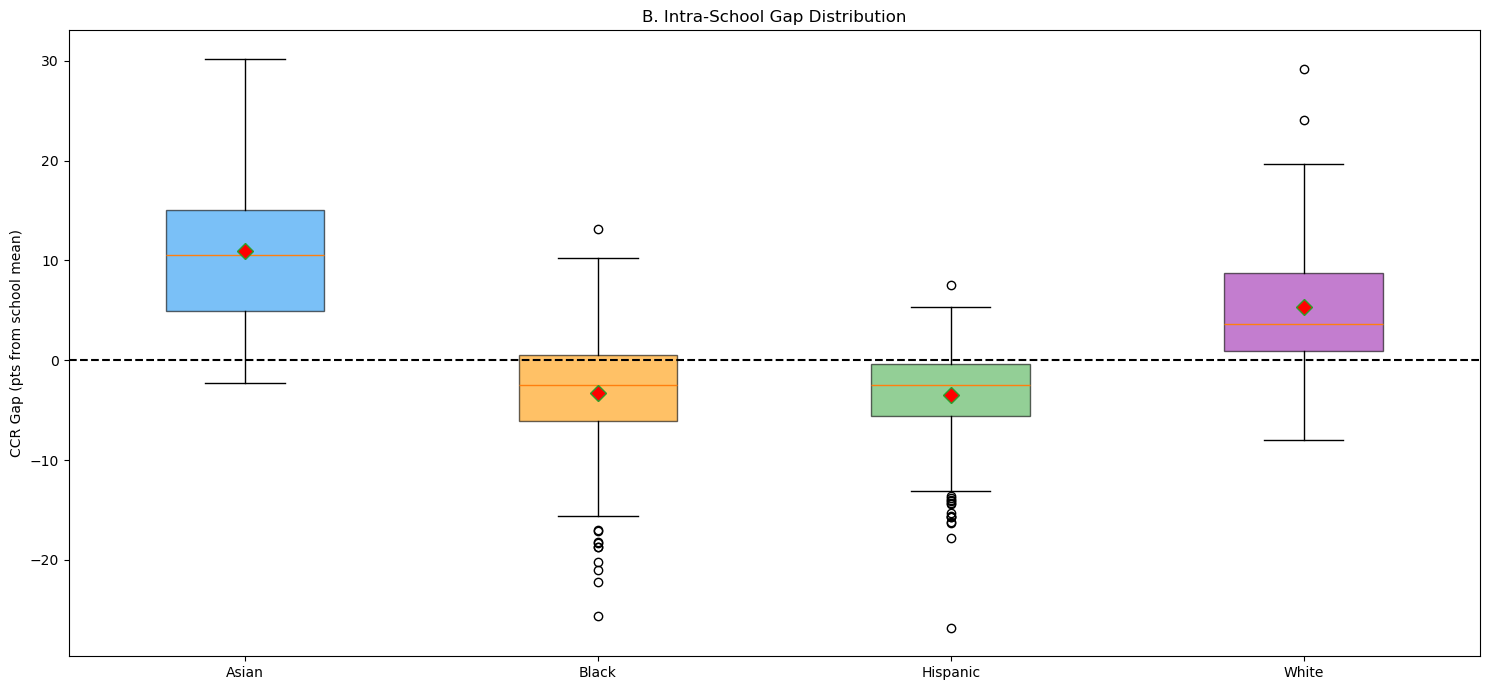


WITHIN-SCHOOL GAP SUMMARY
          Mean Gap  Median Gap  Std    N
Subgroup                                
Asian         10.9        10.6  7.7  118
White          5.4         3.6  6.9   99
Black         -3.3        -2.5  6.0  263
Hispanic      -3.4        -2.5  4.9  305

  → Positive gap = subgroup performs ABOVE school average
  → Negative gap = subgroup performs BELOW school average


In [36]:
# ============================================================
# Within-school subgroup disparities
# ============================================================

# Get schools that report CCR for at least 2 subgroups
multi_sg = reported.groupby('DBN').filter(lambda x: len(x) >= 2).copy()

# Compute school-level mean CCR (school wide reported)
school_mean_ccr = multi_sg.groupby('DBN')['metric_value_4yr_ccr_all_students'].mean().rename('school_mean_ccr')
multi_sg = multi_sg.merge(school_mean_ccr, on='DBN')

# Intra-school gap = subgroup CCR - school mean
multi_sg['intra_school_gap'] = multi_sg['ccr_pct'] - multi_sg['school_mean_ccr']

print(f'Schools with ≥2 subgroups reporting CCR: {multi_sg["DBN"].nunique()}')
print(f'Total observations: {len(multi_sg)}\n')

fig, ax = plt.subplots(figsize=(15, 7))

# --- Panel B: Box plot of intra-school gap ---
gap_box_data = []
gap_labels = []
for sg in ['Asian', 'Black', 'Hispanic', 'White']:
    data = multi_sg[multi_sg['Subgroup'] == sg]['intra_school_gap']
    if len(data) >= 5:
        gap_box_data.append(data.values)
        gap_labels.append(sg)
bp = ax.boxplot(gap_box_data, labels=gap_labels, patch_artist=True, showmeans=True,
                      meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
for patch, sg in zip(bp['boxes'], gap_labels):
    patch.set_facecolor(subgroup_colors[sg])
    patch.set_alpha(0.6)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5)
ax.set_ylabel('CCR Gap (pts from school mean)')
ax.set_title('B. Intra-School Gap Distribution')

plt.tight_layout()
plt.show()

# Summary stats
print('\n' + '=' * 70)
print('WITHIN-SCHOOL GAP SUMMARY')
print('=' * 70)
gap_summary = multi_sg.groupby('Subgroup')['intra_school_gap'].agg(['mean', 'median', 'std', 'count']).round(1)
gap_summary.columns = ['Mean Gap', 'Median Gap', 'Std', 'N']
print(gap_summary.sort_values('Mean Gap', ascending=False).to_string())
print(f'\n  → Positive gap = subgroup performs ABOVE school average')
print(f'  → Negative gap = subgroup performs BELOW school average')

## 4. Missingness Bias Analysis

**The problem:** 56% of subgroup-level CCR observations are missing (suppressed or no cohort). This missingness is **not random** — it's structurally linked to subgroup size, which itself correlates with school characteristics (ENI, borough, demographics). If we ignore this, our subgroup analysis is biased toward schools where the subgroup is large enough to report.

**Key question:** Are the suppressed schools systematically different from the reported ones?

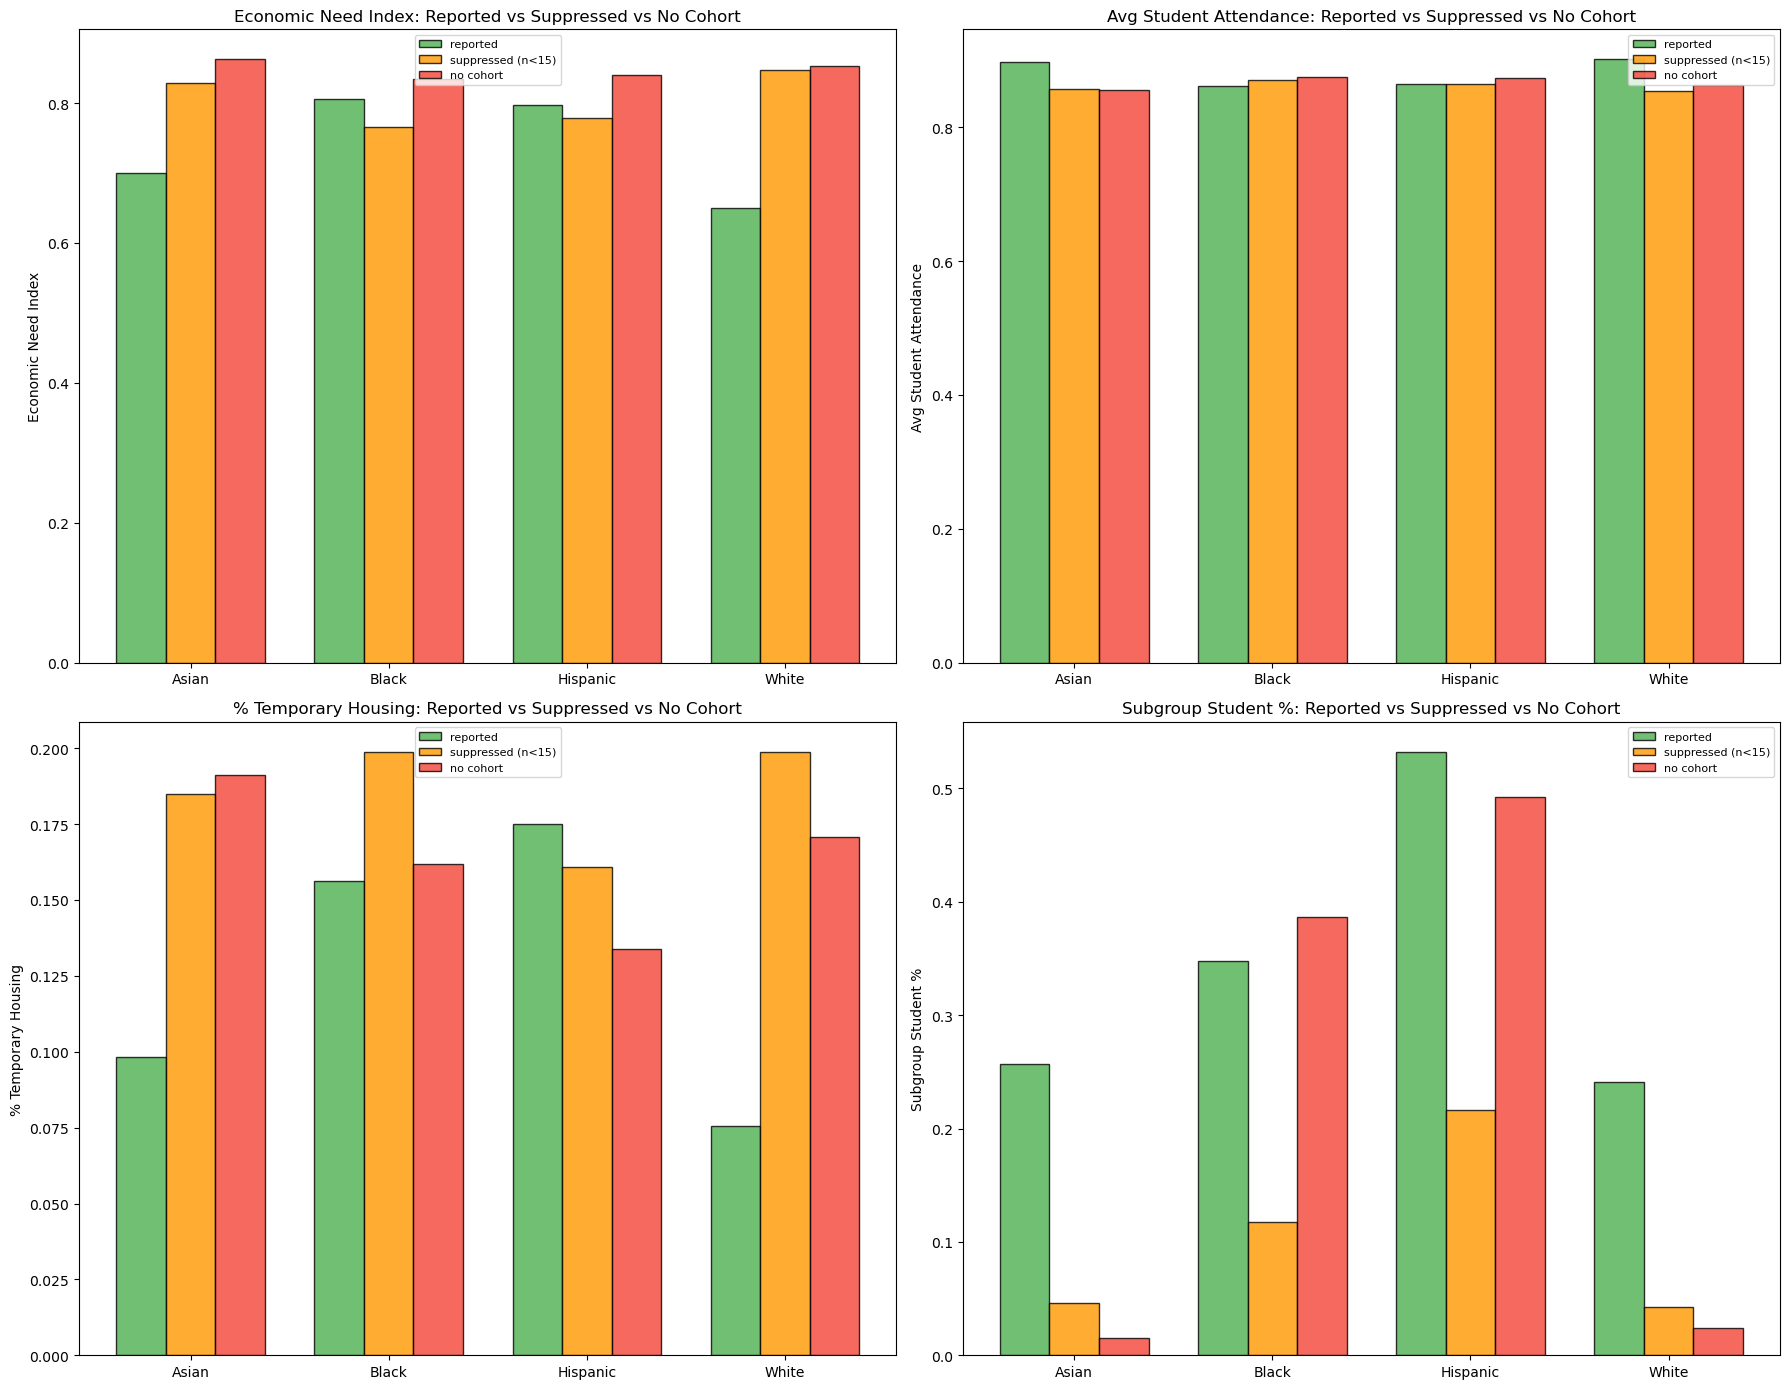

MISSINGNESS BIAS: Reported vs Suppressed School Profiles

Subgroup     Variable                       Reported     Suppressed   Difference   t-stat     p-value   
------------------------------------------------------------------------------------------------
Asian        economic_need_index            0.700      0.828      +0.128       -8.25    0.0000 ***
Asian        avg_student_attendance         0.898      0.857      -0.041        7.38    0.0000 ***
Asian        percent_temp_housing           0.098      0.185      +0.087       -7.87    0.0000 ***

Black        economic_need_index            0.806      0.766      -0.039        2.22    0.0269 *
Black        avg_student_attendance         0.862      0.871      +0.009       -1.58    0.1153 ns
Black        percent_temp_housing           0.156      0.199      +0.042       -3.64    0.0003 ***

Hispanic     economic_need_index            0.798      0.779      -0.018        0.82    0.4107 ns
Hispanic     avg_student_attendance         0.865

In [34]:
# ============================================================
# Missingness bias: comparing reported vs suppressed school profiles
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

compare_vars = {
    'economic_need_index': 'Economic Need Index',
    'avg_student_attendance': 'Avg Student Attendance',
    'percent_temp_housing': '% Temporary Housing',
    'student_percent': 'Subgroup Student %'
}

for ax_idx, (col, label) in enumerate(compare_vars.items()):
    ax = axes.flatten()[ax_idx]
    
    x = np.arange(4)
    bar_w = 0.25
    
    for j, status in enumerate(['reported', 'suppressed (n<15)', 'no cohort']):
        means = []
        for sg in ['Asian', 'Black', 'Hispanic', 'White']:
            sub = subgroup_df[(subgroup_df['Subgroup'] == sg) & (subgroup_df['ccr_status'] == status)]
            means.append(sub[col].mean() if len(sub) > 0 and sub[col].notna().sum() > 0 else 0)
        
        color = ['#4CAF50', '#FF9800', '#f44336'][j]
        ax.bar(x + j * bar_w, means, bar_w, color=color, edgecolor='black', alpha=0.8,
               label=status)
    
    ax.set_xticks(x + bar_w)
    ax.set_xticklabels(['Asian', 'Black', 'Hispanic', 'White'])
    ax.set_ylabel(label)
    ax.set_title(f'{label}: Reported vs Suppressed vs No Cohort')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Statistical comparison: reported vs suppressed
print('=' * 80)
print('MISSINGNESS BIAS: Reported vs Suppressed School Profiles')
print('=' * 80)
print(f'\n{"Subgroup":<12} {"Variable":<30} {"Reported":<12} {"Suppressed":<12} {"Difference":<12} {"t-stat":<10} {"p-value":<10}')
print('-' * 96)

for sg in ['Asian', 'Black', 'Hispanic', 'White']:
    for col in ['economic_need_index', 'avg_student_attendance', 'percent_temp_housing']:
        rep = subgroup_df[(subgroup_df['Subgroup'] == sg) & (subgroup_df['ccr_status'] == 'reported')][col].dropna()
        sup = subgroup_df[(subgroup_df['Subgroup'] == sg) & (subgroup_df['ccr_status'] == 'suppressed (n<15)')][col].dropna()
        
        if len(rep) >= 5 and len(sup) >= 5:
            t_stat, p_val = stats.ttest_ind(rep, sup)
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
            diff = sup.mean() - rep.mean()
            print(f'{sg:<12} {col:<30} {rep.mean():.3f}      {sup.mean():.3f}      {diff:+.3f}      {t_stat:>6.2f}    {p_val:.4f} {sig}')
    print()